В этом кейсе мы создадим первую модель, использующую алгоритмы машинного обучения. Наша задача будет состоять в том, чтобы качественно подготовить данные для обучения модели. Мы будем работать с датасетом, содержащим сведения о 40 000 ресторанах Европы, а модель, которую мы будем обучать, должна будет предсказывать рейтинг ресторана по данным сайта TripAdvisor на основе имеющихся в датасете данных.

# Загрузка Pandas и очистка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta
from collections import Counter
pd.set_option('display.max_rows', 60)  # показывать больше строк
pd.set_option('display.max_columns', 60)
restaurants = pd.read_csv('main_task.xls')

In [2]:
# посмотрим, что из себя представляют данные
display(restaurants.sample(5))

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
19779,id_9205,London,NaN,9214.0,5.0,NaN,NaN,"[['Halal, no alcohol, Great Kurdish food'], ['...",/Restaurant_Review-g186338-d12814073-Reviews-N...,d12814073
9955,id_3213,Prague,"['Bar', 'Czech', 'Central European', 'European...",3220.0,3.5,$$ - $$$,62.0,"[['Interesting', 'Amazing range of food'], ['0...",/Restaurant_Review-g274707-d7138824-Reviews-Ho...,d7138824
22022,id_585,Krakow,"['American', 'Mediterranean', 'European', 'Gri...",586.0,5.0,$$ - $$$,11.0,"[['Familytrip', 'Great steakhouse'], ['10/29/2...",/Restaurant_Review-g274772-d10693510-Reviews-B...,d10693510
28677,id_7115,Madrid,NaN,7119.0,3.0,NaN,11.0,"[[], []]",/Restaurant_Review-g187514-d10784793-Reviews-T...,d10784793
23390,id_67,Hamburg,"['International', 'European', 'German', 'Centr...",68.0,4.5,$$ - $$$,242.0,"[['Very delicious food and service', 'Wonderfu...",/Restaurant_Review-g187331-d718233-Reviews-Nil...,d718233


Первоначальная версия датасета состоит из десяти столбцов, содержащих следующую информацию:
 - Restaurant_id — идентификационный номер ресторана / сети ресторанов;
 - City — город, в котором находится ресторан;
 - Cuisine Style — кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане;
 - Ranking — место, которое занимает данный ресторан среди всех ресторанов своего города;
 - Rating — рейтинг ресторана по данным TripAdvisor (именно это значение должна будет предсказывать модель);
 - Price Range — диапазон цен в ресторане;
 - Number of Reviews — количество отзывов о ресторане;
 - Reviews — данные о двух отзывах, которые отображаются на сайте ресторана;
 - URL_TA — URL страницы ресторана на TripAdvisor;
 - ID_TA — идентификатор ресторана в базе данных TripAdvisor.

Для удобства использования pandas переименуем столбцы:

In [3]:
restaurants.columns = ['res_id', 'city', 'cuisine', 'ranking',
                       'rating', 'price_range', 'rev_num', 'reviews', 'url_ta', 'id_ta']
restaurants.head()

,res_id,city,cuisine,ranking,rating,price_range,rev_num,reviews,url_ta,id_ta
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [4]:
# посмотрим более детальную информацию о колонках
restaurants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   res_id       40000 non-null  object 
 1   city         40000 non-null  object 
 2   cuisine      30717 non-null  object 
 3   ranking      40000 non-null  float64
 4   rating       40000 non-null  float64
 5   price_range  26114 non-null  object 
 6   rev_num      37457 non-null  float64
 7   reviews      40000 non-null  object 
 8   url_ta       40000 non-null  object 
 9   id_ta        40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


## Первичный анализ данных в столбцах

Рассмотрим все столбцы по отдельности

### res_id

In [5]:
pd.DataFrame(restaurants.res_id.value_counts())

,res_id
id_871,18
id_436,18
id_227,18
id_633,18
id_321,17
...,...
id_7032,1
id_6732,1
id_6069,1
id_10865,1


Удалим из данных часть 'id_' и оставим только числовые данные

In [6]:
restaurants['res_id'] = restaurants['res_id'].apply(
    lambda x: x[3:]).astype('int64')

Резюме: res_id. Видим, что представлены как одиночные рестораны, так и сети ресторанов. Пока на данном этапе ничего не могу придумать, что с этими данными можно сделать.

### city

<AxesSubplot:title={'center':'Количество ресторанов по городам'}, xlabel='количество'>

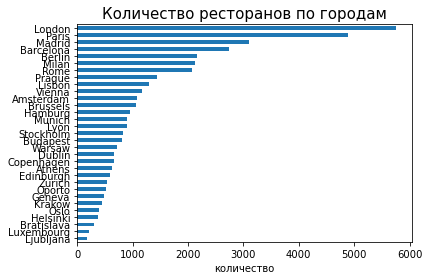

In [7]:
plt.title("Количество ресторанов по городам", fontsize=15)
plt.rcParams['figure.figsize'] = (12, 10)
plt.xlabel('количество')
restaurants['city'].value_counts(ascending=True).plot(kind='barh')

Резюме: city. По всем ресторанам заполнена информация по городу, пропусков нет. Возможно надо сгруппировать города по каким-либо признакам. Сделаем это позже.

### cuisine

In [8]:
restaurants['cuisine'].isna().sum()

9283

9283 пропуска в значениях предлагаемых кухонь в ресторанах отсутствует. Можно предположить, что ресторан не определился с типом кухни. Заменим все пропуски на 'unknown'.

In [9]:
restaurants['cuisine'] = restaurants['cuisine'].fillna("['unknown']")

In [10]:
restaurants.sample(10)

,res_id,city,cuisine,ranking,rating,price_range,rev_num,reviews,url_ta,id_ta
15002,1938,Brussels,['Healthy'],1939.0,4.5,NaN,2.0,"[['Have a Wabi!'], ['06/20/2017']]",/Restaurant_Review-g188644-d12559647-Reviews-W...,d12559647
10060,1198,Oporto,"['European', 'Portuguese']",1199.0,4.0,$,5.0,"[['It was a normal café'], ['10/08/2017']]",/Restaurant_Review-g189180-d8816395-Reviews-O_...,d8816395
8022,2501,Barcelona,['Chinese'],2502.0,4.0,$,33.0,"[['Good value for money', 'Authentic food, sim...",/Restaurant_Review-g187497-d2360816-Reviews-He...,d2360816
26289,3155,Berlin,['Sushi'],3157.0,4.5,NaN,7.0,"[[], []]",/Restaurant_Review-g187323-d8459185-Reviews-I_...,d8459185
10553,367,Berlin,"['Austrian', 'European', 'Central European', '...",368.0,4.5,$$ - $$$,101.0,"[['Impeccable Austrian cuisine', 'Excellent'],...",/Restaurant_Review-g187323-d5967573-Reviews-Ru...,d5967573
8197,1085,Berlin,"['Cafe', 'European', 'Central European', 'Germ...",1087.0,4.0,$$ - $$$,93.0,"[['Nice', 'Good and cozy restaurant!'], ['02/2...",/Restaurant_Review-g187323-d958838-Reviews-Mok...,d958838
5492,5526,Milan,['unknown'],5529.0,3.0,NaN,NaN,"[[], []]",/Restaurant_Review-g187849-d8339754-Reviews-Ca...,d8339754
17751,10002,London,['unknown'],10011.0,4.0,NaN,6.0,"[['A proper caff!', 'Lovely cafe, shame about ...",/Restaurant_Review-g186338-d8844903-Reviews-Th...,d8844903
4960,228,Lisbon,"['Steakhouse', 'Mediterranean', 'Barbecue', 'E...",229.0,4.5,$$ - $$$,248.0,"[['Best Meat Ever!!!', 'Lovely place'], ['01/2...",/Restaurant_Review-g189158-d8656720-Reviews-No...,d8656720
15229,1901,Stockholm,['unknown'],1904.0,3.5,NaN,6.0,"[['Nice city restaurant', 'Nice pizza'], ['04/...",/Restaurant_Review-g189852-d7290707-Reviews-Sk...,d7290707


Резюме: cuisine. Пропуски заполнили. Преобразованиями займемся после.

### ranking

<AxesSubplot:title={'center':'Рейтинг ресторана в своем городе'}, xlabel='место в рейтинге'>

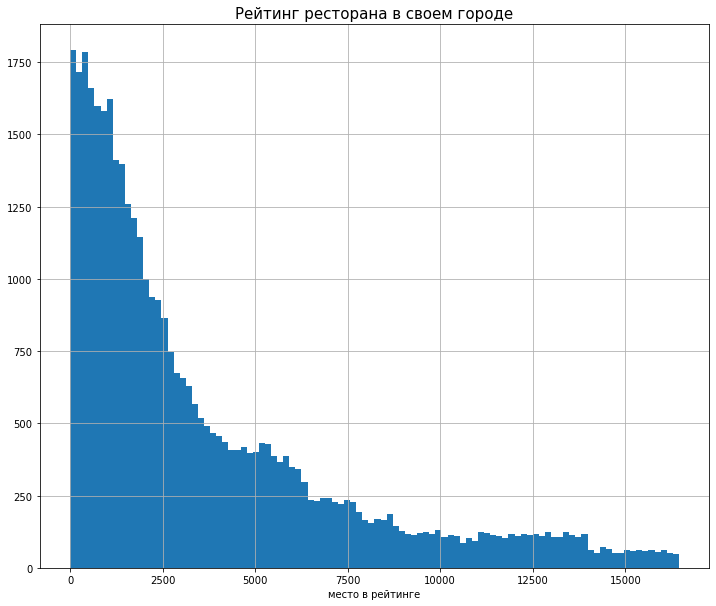

In [11]:
plt.title("Рейтинг ресторана в своем городе", fontsize=15)
plt.rcParams['figure.figsize'] = (12, 10)
plt.xlabel('место в рейтинге')
restaurants['ranking'].hist(bins=100)

Покажем на графике, что рейтинг нарямую зависит от колличества ресторанов в городе.

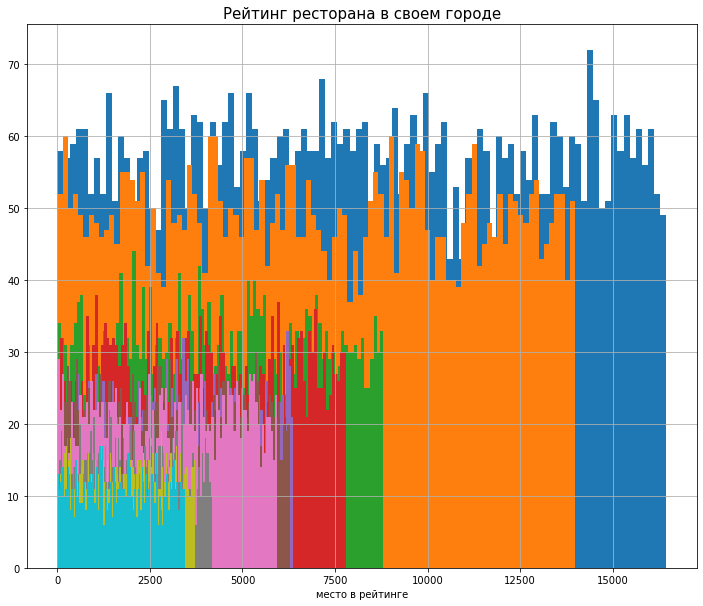

In [12]:
plt.title("Рейтинг ресторана в своем городе", fontsize=15)
plt.rcParams['figure.figsize'] = (10, 7)
plt.xlabel('место в рейтинге')
for x in (restaurants['city'].value_counts())[0:10].index:
    restaurants['ranking'][restaurants['city']
                           == x].hist(bins=100, label='city')
plt.show()

Резюме: ranking. В больших городах - больше ресторанов, поэтому мы имеем смещение. Для машинного обучения необходимо нормализировать данные.

### rating

Рейтинг ресторана - целевая переменная. Посмотрим его распределение.

<AxesSubplot:title={'center':'Рейтинг ресторана'}, xlabel='количество'>

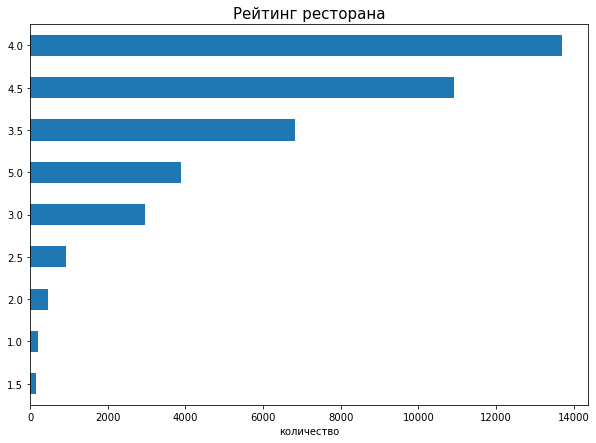

In [13]:
plt.title("Рейтинг ресторана", fontsize=15)
plt.rcParams['figure.figsize'] = (10, 5)
plt.xlabel('количество')
restaurants['rating'].value_counts(ascending=True).plot(kind='barh')

### price_range

In [14]:
restaurants['price_range'].unique()

array(['$$ - $$$', nan, '$$$$', '$'], dtype=object)

In [15]:
restaurants['price_range'].value_counts()

$$ - $$$    18412
$            6279
$$$$         1423
Name: price_range, dtype: int64

В столбце очень много пропусков. Большинство значений (около 70%) приходится на средний диапазон цен. Заполним пропуски модой.

In [16]:
restaurants['price_range'] = restaurants['price_range'].fillna('$$ - $$$')
restaurants['price_range'].value_counts()

$$ - $$$    32298
$            6279
$$$$         1423
Name: price_range, dtype: int64

Резюме: price_range. Очень много пропусков в значениях. Пропуски заполнили модой - средним значением. 'Price Range' это - цены в ресторане. Их можно поставить по возрастанию. А это значит, что их можно заменить последовательными числами, например 1,2,3. Сделаем это позже.

### rev_num

<AxesSubplot:title={'center':'Количество отзывов'}>

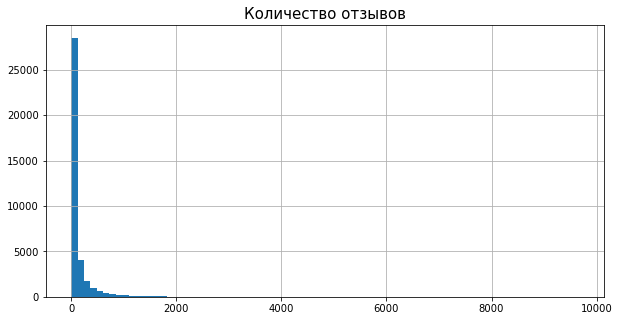

In [17]:
plt.title("Количество отзывов", fontsize=15)
restaurants['rev_num'].hist(bins=80)

In [18]:
restaurants['rev_num'].isnull().sum()

2543

Столбец показывает количество отзывов о ресторане. В нем есть пропуски значений, а может это и не пропуски, просто нет отзывов. И есть несколько ресторанов с очень большим количеством отзывов, более 2000. Это скорее всего выбросы. Пропуски заполним нулем.

In [19]:
restaurants['rev_num'] = restaurants['rev_num'].fillna(0)
restaurants['rev_num'].describe()

count    40000.000000
mean       116.889700
std        287.729821
min          0.000000
25%          7.000000
50%         28.000000
75%        105.000000
max       9660.000000
Name: rev_num, dtype: float64

<AxesSubplot:>

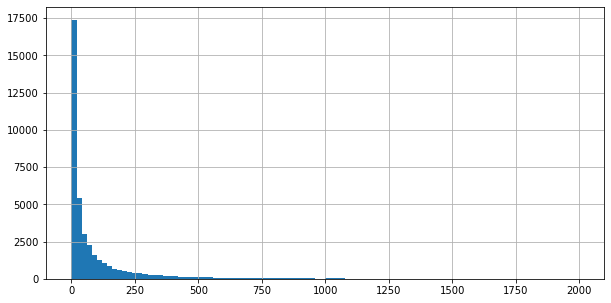

In [20]:
restaurants['rev_num'][restaurants['rev_num'] < 2000].hist(bins=100)

In [21]:
# Создадим функцию для определения границ выбросов.
def IQR(column):
    perc_25 = restaurants[column].quantile(0.25, interpolation="midpoint")
    perc_75 = restaurants[column].quantile(0.75, interpolation="midpoint")
    IQR = perc_75 - perc_25
    print('Q1: {}'.format(perc_25), 'Q3: {}'.format(perc_75), 'IQR: {}'.format(IQR),
          'Граница выбросов: [{a},{b}]'.format(a=perc_25 - 1.5*IQR, b=perc_75 + 1.5*IQR), sep='\n')


IQR('rev_num')

Q1: 7.0
Q3: 105.0
IQR: 98.0
Граница выбросов: [-140.0,252.0]


In [22]:
print(sum(restaurants['rev_num'] > 252))

4758


Очень много значений, которые находятся за пределами выбросов. Скорее всего, это все-таки не выбросы. В больших городах, где много посетителей, оставляют больше отзывов. Можно значения более 1200 заменить на значение 1200. Их не так уж и много.

<AxesSubplot:>

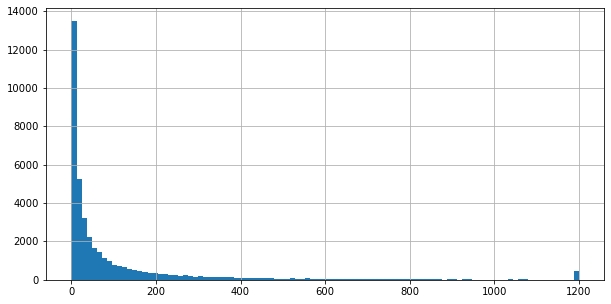

In [23]:
restaurants['rev_num'] = restaurants['rev_num'].apply(
    lambda x: 1200 if x > 1200 else x)
restaurants['rev_num'].hist(bins=100)

Резюме: rev_num. Пропуски в значениях земенили нулями. Возможно у этих ресторанов не было отзывов. Значения больше 1200 заменили на 1200.

### reviews

In [24]:
restaurants['reviews'].isnull().sum()

0

In [25]:
restaurants['reviews'].value_counts()

[[], []]                                                                                   6471
[['The real codido madrileño'], ['03/31/2017']]                                               2
[['Simply Excellent!', 'Modern!'], ['10/22/2017', '08/29/2017']]                              2
[['ok for beer, not for dinner'], ['12/20/2017']]                                             2
[['Thursday snack', 'Good value for money & good food!'], ['03/13/2017', '06/20/2016']]       2
                                                                                           ... 
[['Dinner', 'A place to avoid'], ['08/28/2016', '06/12/2015']]                                1
[['good service and quelity', 'Average'], ['09/20/2017', '09/21/2016']]                       1
[['Really good location to sit outside!', 'Good'], ['10/08/2017', '09/05/2017']]              1
[['Good', 'Decent Dinner for a reasonable price'], ['10/17/2017', '10/02/2017']]              1
[['Delicious Kebabz', 'Really good'], ['

Резюме: reviews. Пропусков в данных с отзывами нет, но присутствуют по сути пустые значения, где нет ни отзыва, ни даты. Также есть данные, где только один отзыв. Пока оставим как есть, в дальнейшем можно будет разделить по категориям: 2 отзыва, 1 отзыв, нет отзывов и посмотреть, как это повлияет на модель.

### url_ta

Есть смысл в данном столбце, если умеешь парсить. Парсинг мы в данной задаче не используем, посмотрим, что можно вытащить.

In [26]:
restaurants['url_ta'].head(5)

0    /Restaurant_Review-g187147-d1912643-Reviews-R_...
1    /Restaurant_Review-g189852-d7992032-Reviews-Bu...
2    /Restaurant_Review-g186338-d8632781-Reviews-RO...
3    /Restaurant_Review-g187323-d1358776-Reviews-Es...
4    /Restaurant_Review-g187309-d6864963-Reviews-Au...
Name: url_ta, dtype: object

In [27]:
restaurants['id_ta'].head(5)

0    d1912643
1    d7992032
2    d8632781
3    d1358776
4    d6864963
Name: id_ta, dtype: object

url ресторана состоит из двух закодированных данных. Первая, судя по совпадениям, означает город, вторая совпадает с id_ta. Оставим только код города.

In [28]:
restaurants['url_ta'] = restaurants['url_ta'].apply(
    lambda x: x[20:26]).astype('int64')

Резюме: url_ta. Оставили только код города.

### id_ta

Также удалим первую букву и оставим только числовое значение.

In [29]:
restaurants['id_ta'] = restaurants['id_ta'].apply(
    lambda x: x[1:]).astype('int64')

In [30]:
restaurants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   res_id       40000 non-null  int64  
 1   city         40000 non-null  object 
 2   cuisine      40000 non-null  object 
 3   ranking      40000 non-null  float64
 4   rating       40000 non-null  float64
 5   price_range  40000 non-null  object 
 6   rev_num      40000 non-null  float64
 7   reviews      40000 non-null  object 
 8   url_ta       40000 non-null  int64  
 9   id_ta        40000 non-null  int64  
dtypes: float64(3), int64(3), object(4)
memory usage: 3.1+ MB


Резюме: пропуски во всех столбцах заполнили, с выбросами разобрались. Далее будем обрабатывать все данные в числовой тип.

## Feature engineering

### price_range

Заменим ценовые значения последовательными числами.

In [31]:
price = {'$': 1, '$$ - $$$': 2, '$$$$': 3}
restaurants['price_range'] = restaurants['price_range'].apply(
    lambda x: price[x]).astype('int64')

Добавим признак, относится ли ресторан к среднему ценовому сегменту. (0 - нет, 1 - да)

In [32]:
restaurants['medium_price'] = restaurants['price_range'].apply(
    lambda x: 1 if x == 2 else 0)

### reviews

Вытащим даты из отзывов и создадим новую переменную, которая показывает количество отзывов 0, 1 или 2.

In [33]:
restaurants['date_reviews'] = restaurants['reviews'].str.findall('\d+/\d+/\d+')
restaurants['len_date'] = restaurants['date_reviews'].apply(lambda x: len(x))
restaurants['len_date'].value_counts()

2    28971
0     6471
1     4556
3        2
Name: len_date, dtype: int64

В 2 строчках оказалось по 3 даты. Посмотрим что в них.

In [34]:
restaurants[restaurants['len_date']==3]

,res_id,city,cuisine,ranking,rating,price_range,rev_num,reviews,url_ta,id_ta,medium_price,date_reviews,len_date
9254,12965,London,"['Cafe', 'French']",12975.0,3.5,2,31.0,"[['The desserts arcade !', 'Visit today 3/1/20...",186338,1017372,1,"[3/1/2017, 06/02/2017, 01/03/2017]",3
23348,450,Geneva,"['French', 'European']",453.0,4.0,2,48.0,"[['lunch 29/9/2016', 'Unplanned Great Dinner']...",188057,2706773,1,"[29/9/2016, 09/30/2016, 08/25/2016]",3


В отзывах указана дата и эти даты попали в обработку, исправим эту ситуацию.

In [35]:
restaurants['len_date'].date_reviews = restaurants[restaurants['len_date']
                                                  == 3].date_reviews.apply(lambda x: x.pop(0))
restaurants['len_date'] = restaurants['date_reviews'].apply(lambda x: len(x))
restaurants['len_date'].value_counts()

2    28973
0     6471
1     4556
Name: len_date, dtype: int64

Добавим признаки, которые будет показывать, как давно был сделан самый последний отзыв и время между отзывами.

In [36]:
def time_to_now(row):
    if row['date_reviews'] == []:
        return None
    return datetime.now() - pd.to_datetime(row['date_reviews']).max()


def time_between_reviews(row):
    if row['date_reviews'] == []:
        return None
    return pd.to_datetime(row['date_reviews']).max() - pd.to_datetime(row['date_reviews']).min()


restaurants['day_to_now'] = restaurants.apply(time_to_now, axis=1).dt.days
restaurants['day_to_now'] = restaurants['day_to_now'].fillna(0)
restaurants['day_between_reviews'] = restaurants[restaurants['len_date']
                                                 == 2].apply(time_between_reviews, axis=1).dt.days
restaurants['day_between_reviews'] = restaurants['day_between_reviews'].fillna(
    0)

### cuisine

Добавим новую переменную, обозначающую количество кухонь в ресторане.

In [37]:
restaurants['cuisine_new'] = restaurants['cuisine'].apply(lambda x: eval(x))
restaurants['cuisine_count'] = restaurants['cuisine_new'].apply(lambda x: len(x)).astype('int64')
restaurants['cuisine_count'].value_counts()

1     16547
2      6294
3      5306
4      4799
5      3606
6      2043
7      1022
8       283
9        76
10       19
11        3
21        1
13        1
Name: cuisine_count, dtype: int64

Поработаем с кухнями. Создадим коллекцию с количеством различных кухонь. Добавим несколько переменных, которые будут показывать, имеет ли ресторан кухню, входящую в топ-N по популярности и по уникальности. Также затем сократим количество до N популярных, остальным присвоим other. 

In [38]:
restaurants['cuisine'] = restaurants['cuisine'].str.findall(r"'(\b.*?\b)'")

cuisine_list = restaurants['cuisine'].tolist()


def cuisine_col(lst):
    result = []
    for i in lst:
        result.extend(i)
    return result


cuisine_collection = Counter(cuisine_col(cuisine_list))

unique_cuisine = [x[0] for x in cuisine_collection.most_common()[-10:]]
restaurants['unique_cuisine'] = restaurants['cuisine'].apply(lambda x: 1 if len(
    set(x) & set(unique_cuisine)) > 0 else 0).astype('float64')
popular_cuisine = [x[0] for x in cuisine_collection.most_common()[:10]]
restaurants['popular_cuisine'] = restaurants['cuisine'].apply(lambda x: 1 if len(
    set(x) & set(popular_cuisine)) > 0 else 0).astype('float64')

### city

Преобразуем признак city в dummy-переменные.

In [39]:
city_dummies = pd.get_dummies(restaurants['city'], dummy_na=False).astype('int64')
restaurants = pd.concat([restaurants, city_dummies], axis=1)

In [40]:
restaurants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 50 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   res_id               40000 non-null  int64  
 1   city                 40000 non-null  object 
 2   cuisine              40000 non-null  object 
 3   ranking              40000 non-null  float64
 4   rating               40000 non-null  float64
 5   price_range          40000 non-null  int64  
 6   rev_num              40000 non-null  float64
 7   reviews              40000 non-null  object 
 8   url_ta               40000 non-null  int64  
 9   id_ta                40000 non-null  int64  
 10  medium_price         40000 non-null  int64  
 11  date_reviews         40000 non-null  object 
 12  len_date             40000 non-null  int64  
 13  day_to_now           40000 non-null  float64
 14  day_between_reviews  40000 non-null  float64
 15  cuisine_new          40000 non-null 

In [41]:
# добавим признак - является ли город столицей (1 - да, 0 - нет)
capital = ['Amsterdam', 'Athens', 'Berlin', 'Bratislava', 'Brussels', 'Budapest', 'Copenhagen', 'Dublin', 'Helsinki',
           'Lisbon', 'Ljubljana', 'London', 'Luxembourg', 'Madrid', 'Oslo', 'Paris',  'Prague', 'Rome', 'Stockholm', 'Vienna', 'Warsaw']
restaurants['capital'] = restaurants['city'].apply(
    lambda x: 1 if x in capital else 0)
# никак не влияет на метрику, поэтому скорее всего удалим

In [42]:
# признак население на 2018 год, так как данные примерно на то время (по информации из Википедии)
population = {
    'Amsterdam': 859732,
    'Athens': 655780,
    'Barcelona': 1620343,
    'Berlin': 3769495,
    'Bratislava': 437726,
    'Brussels': 1198726,
    'Budapest': 1749734,
    'Copenhagen': 615993,
    'Dublin': 553165,
    'Edinburgh': 488050,
    'Geneva': 201818,
    'Hamburg': 1830584,
    'Helsinki': 643272,
    'Krakow': 766739,
    'Lisbon': 506654,
    'Ljubljana': 295504,
    'London': 8787892,
    'Luxembourg': 626108,
    'Lyon': 515695,
    'Madrid': 3334730,
    'Milan': 1366180,
    'Munich': 1456039,
    'Oporto': 287591,
    'Oslo': 673469,
    'Paris': 2140526,
    'Prague': 1280508,
    'Rome': 2860009,
    'Stockholm': 961609,
    'Vienna': 1840573,
    'Warsaw': 1758143,
    'Zurich': 415215,
}

restaurants['population'] = restaurants['city'].map(population)

In [43]:
# количество ресторанов для города
restaurants_count_city = restaurants.groupby('city')['ranking'].count().to_dict()
restaurants['restaurants_count_city'] = restaurants['city'].map(restaurants_count_city)

In [44]:
# Вычисляем к-во ресторанов на 1000 чел для города
restaurants['restaurants&Population'] = restaurants['restaurants_count_city'] / (restaurants['population']/1000)

In [45]:
# Признак - индекс покупательской способности согласно рейтингу Numbeo (2018)

purchasing_power_index = {
    'Amsterdam' : 101.70,
    'Athens' : 52.86,
    'Barcelona' : 77.27,
    'Berlin' : 114.09,
    'Bratislava' : 72.75,
    'Brussels' : 104.35,
    'Budapest' : 55.54,
    'Copenhagen' : 113.31,
    'Dublin' : 88.11,
    'Edinburgh' : 104.25,
    'Geneva' : 130.96,
    'Hamburg' : 116.06,
    'Helsinki' : 113.87,
    'Krakow' : 73.59,
    'Lisbon' : 58.48,
    'Ljubljana' : 74.70,
    'London' : 92.61,
    'Luxembourg' : 127.42,
    'Lyon' : 101.25,
    'Madrid' : 96.36,
    'Milan' : 71.94,
    'Munich' : 118.19,
    'Oporto' : 63.31,
    'Oslo' : 102.94,
    'Paris' : 97.62,
    'Prague' : 77.13,
    'Rome' : 72.78,
    'Stockholm' : 108.20,
    'Vienna' : 98.88,
    'Warsaw' : 77.31,
    'Zurich' : 142.70   
}

restaurants['purchasing_power_index'] = restaurants['city'].map(purchasing_power_index)

Добавим признак туристической привлекательности города.
Место города в рейтинге топ-100 городов посещения в 2018 году, так как датасет устаревший (источник - Euromonitor international)

Так как не все города входят в топ-100, то города делим на группы:
 - 1 - место 1-25
 - 2 - место 26-50
 - 3 - место 51-75
 - 4 - место 76-100
 - 5 - место выше 100

In [46]:
tourist_attraction = {
    'London' : 1,
    'Paris' : 1,
    'Madrid' : 2,
    'Barcelona' : 2,
    'Berlin' : 2,
    'Milan' : 4,
    'Rome' : 1,
    'Prague' : 1,
    'Lisbon' : 3,
    'Vienna' : 2,
    'Amsterdam' : 1,
    'Brussels' : 2,
    'Hamburg' : 5,
    'Munich' : 3,
    'Lyon' : 5,
    'Stockholm' : 3,
    'Budapest' : 3,
    'Warsaw' : 3,
    'Dublin' : 5,
    'Copenhagen' : 3,
    'Athens' : 2,
    'Edinburgh' : 4, 
    'Zurich' : 5,
    'Oporto' : 4,
    'Geneva' : 5, 
    'Krakow' : 3, 
    'Oslo' : 4, 
    'Helsinki' : 4,
    'Bratislava' : 5,
    'Luxembourg' : 4,
    'Ljubljana' : 5
}

restaurants['tourist_attraction'] = restaurants['city'].map(tourist_attraction)

In [47]:
# признак максимального ранга по городу и признак ранга относительно максимального в городе
city_max_ranking = restaurants.groupby('city')['ranking'].max()
restaurants['city_max_ranking'] = restaurants['city'].map(city_max_ranking)
restaurants['norm_ranking'] = restaurants['ranking'] / restaurants['city_max_ranking']
# относительная позиция ресторана среди всех ресторанов города
restaurants['relative_ranking'] = restaurants['ranking'] / restaurants['restaurants_count_city']

In [48]:
# def get_Weighed_Rank(row):
#     i = 0
#     city_min = CityMinMax[CityMinMax['city'] == row.city]['min'].iloc[0]
#     city_max = CityMinMax[CityMinMax['city'] == row.city]['max'].iloc[0]
#     Weighed_Rank = round(
#         1-(row['ranking'] - city_min)/(city_max - city_min), 3)
#     # print('<---',Weighed_Rank,'--->')
#     return Weighed_Rank


# CityMinMax = restaurants.groupby('city')['ranking'].agg([min, max])
# CityMinMax = CityMinMax.reset_index()
# restaurants['Weighed Rank min max'] = restaurants.apply(lambda x: get_Weighed_Rank(x), axis=1)
restaurants['num_rev_pop'] = restaurants['rev_num'] / restaurants['population']
restaurants['weighed_rank_pop'] = restaurants['relative_ranking']*restaurants['num_rev_pop']

In [49]:
restaurants.sample(5)

,res_id,city,cuisine,ranking,rating,price_range,rev_num,reviews,url_ta,id_ta,medium_price,date_reviews,len_date,day_to_now,day_between_reviews,cuisine_new,cuisine_count,unique_cuisine,popular_cuisine,Amsterdam,Athens,Barcelona,Berlin,Bratislava,Brussels,Budapest,Copenhagen,Dublin,Edinburgh,Geneva,...,Helsinki,Krakow,Lisbon,Ljubljana,London,Luxembourg,Lyon,Madrid,Milan,Munich,Oporto,Oslo,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich,capital,population,restaurants_count_city,restaurants&Population,purchasing_power_index,tourist_attraction,city_max_ranking,norm_ranking,relative_ranking,num_rev_pop,weighed_rank_pop
19225,490,Oslo,"[Pizza, European, Italian]",491.0,4.0,2,27.0,"[['Neighborhood Pizza', 'Pizza'], ['09/22/2017...",190479,5970363,1,"[09/22/2017, 03/09/2017]",2,1264.0,197.0,"[Pizza, European, Italian]",3,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,673469,385,0.571667,102.94,4,1137.0,0.431838,1.275325,0.000040,0.000051
10392,836,Amsterdam,"[Dutch, Bar, European, Vegetarian Friendly]",838.0,4.0,2,205.0,"[['Big Portion', 'Great bar and restaurant'], ...",188590,4207070,1,"[12/19/2017, 11/24/2017]",2,1176.0,25.0,"[Dutch, Bar, European, Vegetarian Friendly]",4,0.0,1.0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,859732,1086,1.263184,101.70,1,3249.0,0.257926,0.771639,0.000238,0.000184
35999,6998,London,"[British, Contemporary]",7007.0,4.5,3,47.0,"[['Graduation Ceremony and Reception', 'Fantas...",186338,2003041,0,"[06/17/2017, 03/22/2017]",2,1361.0,87.0,"[British, Contemporary]",2,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,8787892,5757,0.655106,92.61,1,16444.0,0.426113,1.217127,0.000005,0.000007
13019,391,Rome,"[Italian, Vegetarian Friendly, Vegan Options, ...",392.0,4.5,2,1200.0,"[['Excellent', 'If you want Italian pasta'], [...",187791,1787162,1,"[01/05/2018, 01/02/2018]",2,1159.0,3.0,"[Italian, Vegetarian Friendly, Vegan Options, ...",4,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,2860009,2078,0.726571,72.78,1,5946.0,0.065927,0.188643,0.000420,0.000079
20235,3229,Rome,"[Italian, Bar, Pizza, Pub, Vegetarian Friendly...",3230.0,3.5,2,606.0,"[['Saturday night for pizza', 'Really a nice s...",187791,7283610,1,"[01/07/2017, 12/12/2016]",2,1522.0,26.0,"[Italian, Bar, Pizza, Pub, Vegetarian Friendly...",6,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,2860009,2078,0.726571,72.78,1,5946.0,0.543222,1.554379,0.000212,0.000329


In [50]:
# нормализация признаков
# def normalization(x, x_min, x_max):
#     return (x-x_min)/(x_max-x_min)


# def get_min_max_normalization(df, column):
#     x_min, x_max = df[column].agg(['min', 'max'])
#     return normalization(df[column], x_min, x_max)

# restaurants['ranking'] = get_min_max_normalization(restaurants, 'ranking')
# restaurants['rev_num'] = get_min_max_normalization(restaurants, 'rev_num')
# restaurants['day_to_now'] = get_min_max_normalization(restaurants, 'day_to_now')
# restaurants['day_between_reviews'] = get_min_max_normalization(restaurants, 'day_between_reviews')
# restaurants['cuisine_count'] = get_min_max_normalization(restaurants, 'cuisine_count')
# restaurants['population'] = get_min_max_normalization(restaurants, 'population')
# restaurants['restaurants_count_city'] = get_min_max_normalization(restaurants, 'restaurants_count_city')
# restaurants['purchasing_power_index'] = get_min_max_normalization(restaurants, 'purchasing_power_index')
# restaurants['tourist_attraction'] = get_min_max_normalization(restaurants, 'tourist_attraction')
# restaurants['city_max_ranking'] = get_min_max_normalization(restaurants, 'city_max_ranking')

Удаляем столбцы, которые не содержат числовых переменных и которые экспериментально ухудшают поведение модели.

In [51]:
restaurants = restaurants.drop(
    ['city', 'cuisine', 'reviews', 'date_reviews', 'cuisine_new', 'url_ta', 'capital'], axis=1)
restaurants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 54 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   res_id                  40000 non-null  int64  
 1   ranking                 40000 non-null  float64
 2   rating                  40000 non-null  float64
 3   price_range             40000 non-null  int64  
 4   rev_num                 40000 non-null  float64
 5   id_ta                   40000 non-null  int64  
 6   medium_price            40000 non-null  int64  
 7   len_date                40000 non-null  int64  
 8   day_to_now              40000 non-null  float64
 9   day_between_reviews     40000 non-null  float64
 10  cuisine_count           40000 non-null  int64  
 11  unique_cuisine          40000 non-null  float64
 12  popular_cuisine         40000 non-null  float64
 13  Amsterdam               40000 non-null  int64  
 14  Athens                  40000 non-null

In [52]:
# Посмотрим на корреляцию признаков
restaurants.corr()

,res_id,ranking,rating,price_range,rev_num,id_ta,medium_price,len_date,day_to_now,day_between_reviews,cuisine_count,unique_cuisine,popular_cuisine,Amsterdam,Athens,Barcelona,Berlin,Bratislava,Brussels,Budapest,Copenhagen,Dublin,Edinburgh,Geneva,Hamburg,Helsinki,Krakow,Lisbon,Ljubljana,London,Luxembourg,Lyon,Madrid,Milan,Munich,Oporto,Oslo,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich,population,restaurants_count_city,restaurants&Population,purchasing_power_index,tourist_attraction,city_max_ranking,norm_ranking,relative_ranking,num_rev_pop,weighed_rank_pop
res_id,1.000000,1.000000,-0.368308,-0.026516,-0.272674,0.048820,0.054692,-0.139894,0.008504,0.065667,-0.320270,-0.006050,-0.160719,-0.094470,-0.095171,0.017545,-0.026302,-0.075655,-0.095193,-0.095497,-0.094284,-0.094986,-0.092950,-0.088341,-0.097580,-0.081647,-0.087338,-0.088901,-0.062802,0.499647,-0.065853,-0.096407,0.055780,-0.036948,-0.094304,-0.090258,-0.082594,0.328329,-0.083504,-0.043613,-0.094929,-0.092006,-0.095837,-0.091156,0.567990,0.709094,0.099243,0.016452,-0.488333,0.709171,0.572100,0.553090,-0.266777,-0.141111
ranking,1.000000,1.000000,-0.368371,-0.026525,-0.272718,0.048826,0.054696,-0.139815,0.008548,0.065661,-0.320250,-0.006048,-0.160754,-0.094372,-0.095177,0.017390,-0.026367,-0.075669,-0.095232,-0.095534,-0.094270,-0.094965,-0.092951,-0.088282,-0.097555,-0.081664,-0.087357,-0.088900,-0.062811,0.499991,-0.065863,-0.096448,0.055754,-0.036981,-0.093938,-0.090281,-0.082608,0.328009,-0.083389,-0.043718,-0.094931,-0.092039,-0.095860,-0.091098,0.568259,0.709115,0.098941,0.016586,-0.488316,0.709194,0.572154,0.553154,-0.266817,-0.141133
rating,-0.368308,-0.368371,1.000000,-0.028588,0.027081,0.159111,-0.087754,0.020550,-0.024710,-0.065990,0.120059,0.003844,0.067074,0.034535,0.044792,-0.012890,0.046967,-0.002988,-0.020753,0.020950,-0.001443,0.013431,0.017489,-0.005027,0.006539,-0.006737,0.024333,0.014565,0.012068,-0.023273,-0.008559,-0.010079,-0.083462,-0.059704,0.012207,0.031603,-0.014680,-0.028288,0.011442,0.083082,-0.026604,0.022037,0.019617,0.008197,-0.025814,-0.061376,-0.037440,-0.031820,-0.010889,-0.061097,-0.544573,-0.542702,0.034371,-0.188931
price_range,-0.026516,-0.026525,-0.028588,1.000000,0.125776,-0.056380,0.589555,-0.076373,-0.058712,-0.039184,0.003177,0.003060,0.132084,-0.000058,-0.020393,-0.013883,-0.005090,0.009290,0.011326,-0.026396,0.017700,-0.015349,-0.034082,0.040465,0.022286,0.002855,-0.029583,-0.025470,-0.005081,-0.018934,0.019274,0.022199,0.025759,-0.020068,0.023440,-0.026726,0.019273,0.045851,-0.019972,-0.054426,0.031190,0.013234,0.002334,0.026925,-0.017146,0.006220,0.023279,0.097287,0.021280,0.006264,-0.047477,-0.046487,0.081954,0.018059
rev_num,-0.272674,-0.272718,0.027081,0.125776,1.000000,-0.359510,-0.048460,0.274194,0.043528,-0.100416,0.503554,-0.000566,0.158352,0.016746,-0.017638,0.007300,-0.058164,-0.028358,-0.022156,0.009651,-0.013998,0.016300,0.058017,-0.027366,-0.049380,-0.024685,0.000106,0.000708,-0.012769,0.018270,-0.010863,-0.019570,-0.029790,0.053969,-0.027747,0.003784,-0.008807,0.004655,-0.011699,0.163036,-0.025753,-0.032740,-0.034982,-0.020706,0.021856,0.035867,0.020629,-0.100557,-0.057975,0.035683,-0.501772,-0.502239,0.678235,0.310713
id_ta,0.048820,0.048826,0.159111,-0.056380,-0.359510,1.000000,0.019000,-0.309054,-0.264912,-0.194297,-0.220633,0.007869,-0.027083,0.014134,0.021846,0.022333,-0.010728,0.011933,-0.001177,0.022222,0.008795,-0.003607,-0.015230,-0.018208,-0.028304,-0.001786,0.024196,0.047473,0.005417,-0.039772,-0.011803,0.000784,0.057148,0.007494,-0.029781,0.050315,-0.004138,-0.061603,0.004768,-0.015494,-0.003784,-0.001942,0.052934,-0.021534,-0.041385,-0.058442,-0.005572,-0.081160,0.027567,-0.059072,0.168795,0.168365,-0.244103,-0.223677
medium_price,0.054692,0.054696,-0.087754,0.589555,-0.048460,0.019000,1.000000,-0.150475,-0.079029,-0.017445,-0.118458,-0.011464,0.101704,0.005894,-0.017381,-0.010695,0.010094,0.010974,0.011883,-0.021923,0.012398,-0.003655,-0.031002,0.017809,0.029466,0.007490,-0.024658,-0.017050,-0.00

In [53]:
# удалим признак 'res_id', он коррелирует с признаком 'ranking'
restaurants = restaurants.drop(['res_id'], axis=1)
restaurants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 53 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ranking                 40000 non-null  float64
 1   rating                  40000 non-null  float64
 2   price_range             40000 non-null  int64  
 3   rev_num                 40000 non-null  float64
 4   id_ta                   40000 non-null  int64  
 5   medium_price            40000 non-null  int64  
 6   len_date                40000 non-null  int64  
 7   day_to_now              40000 non-null  float64
 8   day_between_reviews     40000 non-null  float64
 9   cuisine_count           40000 non-null  int64  
 10  unique_cuisine          40000 non-null  float64
 11  popular_cuisine         40000 non-null  float64
 12  Amsterdam               40000 non-null  int64  
 13  Athens                  40000 non-null  int64  
 14  Barcelona               40000 non-null

# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [54]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
X = restaurants.drop(['rating'], axis = 1)
y = restaurants['rating']

In [55]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [56]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Создаём, обучаем и тестируем модель

In [57]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [58]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

Значения рейтинга представлены с шагом 0,5. Округлим результат работы модели:

In [59]:
y_pred = (y_pred*2).round()/2

In [60]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.16835


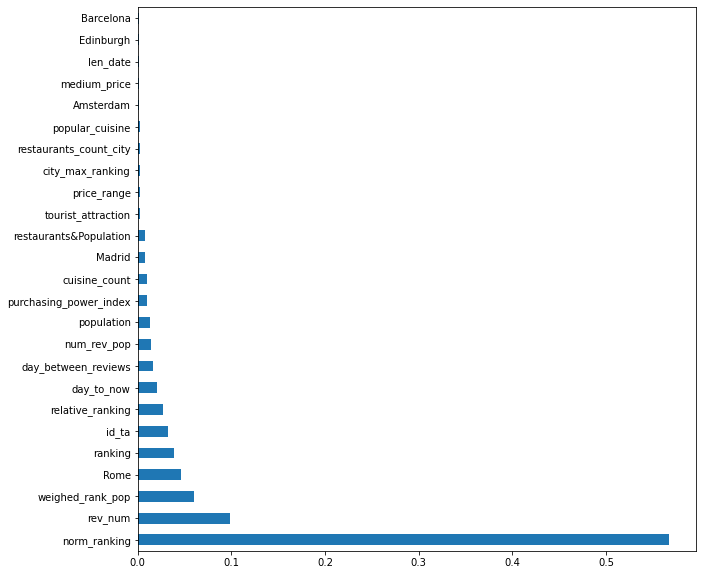

In [61]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(25).plot(kind='barh')
plt.show()